In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import dask

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

from myfunc import mysom, mytrack, myfunc
import os
%config InlineBackend.figure_format='retina'

In [2]:
# Parameters
projectdir = '/rcfs/projects/windpower_wfip2uq/liuy351/Tracer'
met_extent    = [-120, -70, 15, 50]
track_extent  = [-97, -93, 28, 32]
som_extent    = [-105, -90, 26, 37]
pcptypes  = ["Total", "MCS", "IDC", "TC", "NC"]

figdir = './som_fig'
os.makedirs(figdir, exist_ok=True)

# Controlling variables
flag_mkdata=True
year1 = 2004
year2 = 2017

In [3]:
mapsize = (2,2)
factor  =('u','v','q')

In [4]:
def calc_track_path(tracks, year):
    mdir = "../MCS_IDC_database/stats_linkpf"
    track_paths = []
    for iy in np.arange(year[0], year[1]+1):
        track = tracks.sel(tracks=(tracks["tracks"].data / 100000).astype(int)==iy)
        ds = xr.open_dataset(f"{mdir}/robust_mcs_tracks_{iy}0101_{iy}1231.nc")
        ds.coords["tracks"] = ds.tracks + iy * 100000
        # print(track.data)
        # print(list(ds.keys()))
        track = np.intersect1d(track.data, ds.tracks.data)
        track_paths.append(ds.sel(tracks=track)[["meanlat", "meanlon", "pf_ccrate", "pf_sfrate"]])
        # print(ds.sel(tracks=track)[["meanlat", "meanlon", "pf_rainrate"]])
    return track_paths

In [5]:
Path = {}

for season in ['MAM', 'JJA', 'SON', 'DJF']:
    for pcptype in ['mcs', 'idc']:
        outname = mytrack.create_outname(f"{pcptype}_location", (year1,year2))
        tracks  = mytrack.load_data_idc(outname, (year1,year2), season)#, extent=track_extent)
        
        fname_bmu = mysom.bmu_filename(mapsize, factor, season, pcptype)
        bmu  = mysom.read_bmu(fname_bmu, season, pcptype=pcptype, flag_swap=True, flag_cluster=False)
        track_clusters = mysom.calc_cluster_track_mapsize(tracks, bmu, mapsize=mapsize)
        
        for isom, itrack in enumerate(track_clusters):
            track_paths = calc_track_path(itrack, (year1,year2))
            Path[f'{season}_{pcptype}_{isom}'] = track_paths



MAM
swaping bmu....
MAM
swaping bmu....
JJA
swaping bmu....
JJA
swaping bmu....
SON
swaping bmu....
SON
swaping bmu....
DJF
swaping bmu....
DJF
swaping bmu....


In [6]:
Path['MAM_mcs_1'][0]

<xarray.Dataset>
Dimensions:    (tracks: 2, times: 134)
Coordinates:
  * tracks     (tracks) int32 200404089 200404537
  * times      (times) float32 0.0 1.0 2.0 3.0 4.0 ... 130.0 131.0 132.0 133.0
Data variables:
    meanlat    (tracks, times) float32 ...
    meanlon    (tracks, times) float32 ...
    pf_ccrate  (tracks, times) float32 ...
    pf_sfrate  (tracks, times) float32 ...
Attributes: (12/22)
    title:                          Robust MCS statistics defined by radar pr...
    source1:                        gpmmergir
    description:                    eus
    startdate:                      20040101
    enddate:                        20041231
    _FillValue:                     -999
    ...                             ...
    MCS_PF_length_thres_km:         20.0
    convection_PF_majoraxis_km:     3.9
    convection_PF_duration_hour:    0.5
    convection_PF_length_thres_km:  3.9
    contact:                        Jianfeng Li: jianfeng.li@pnnl.gov; Zhe Fe...
    created_on:                     Mon May  4 15:34:23 2020

In [7]:
def find_in(path):
    rr = track_extent
    if path.tracks.size == 0: return [99]
    lon, lat = path.isel(times=0)['meanlon'].data, path.isel(times=0)['meanlat'].data
    result = []
    for ilon, ilat in zip(lon, lat):
        if (ilon>=rr[0])&(ilon<=rr[1])&(ilat>=rr[2])&(ilat<=rr[3]):
            result.append(1)
        else:
            result.append(0)
    return result

inout = [find_in(path) for path in Path['JJA_idc_3']]
inout = np.concatenate(inout)
inout = inout[inout!=99]
print(track_extent)
print(inout)
100-inout.sum()/inout.size*100.

[-97, -93, 28, 32]
[1 1 1 ... 1 1 1]


5.349661617789238

In [8]:
Path.keys()

dict_keys(['MAM_mcs_0', 'MAM_mcs_1', 'MAM_mcs_2', 'MAM_mcs_3', 'MAM_idc_0', 'MAM_idc_1', 'MAM_idc_2', 'MAM_idc_3', 'JJA_mcs_0', 'JJA_mcs_1', 'JJA_mcs_2', 'JJA_mcs_3', 'JJA_idc_0', 'JJA_idc_1', 'JJA_idc_2', 'JJA_idc_3', 'SON_mcs_0', 'SON_mcs_1', 'SON_mcs_2', 'SON_mcs_3', 'SON_idc_0', 'SON_idc_1', 'SON_idc_2', 'SON_idc_3', 'DJF_mcs_0', 'DJF_mcs_1', 'DJF_mcs_2', 'DJF_mcs_3', 'DJF_idc_0', 'DJF_idc_1', 'DJF_idc_2', 'DJF_idc_3'])

In [9]:
from yllib.plot import plot_map
import cartopy.crs as ccrs
from matplotlib import cm

def plot_on_map(data, **kwargs):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  

    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    
    plot_map.set_map(
        ax,
        # extent=met_extent,
        extent=[-105,-85,25,40],
        gridlines_kw=dict(
            xticks=[-110,-100,-90,-80],
            yticks=[30,35,45],
            linestyle=":", alpha=0.3,
        ),
        gridlabels_kw=dict(
            xticks=[-110,-100,-90,-80] if kwargs.get('drawxlabel', False) else [],
            yticks=[30,35,45] if kwargs.get('drawylabel', False) else [],
        ),
        boundary_kw=dict(
            coastline_kw=dict(linewidth=1.2, alpha=0.8, color='k'),
        ),
    )
    # plot_map.add_rectangle(ax, [-110, -80, 20, 45], ec="k", lw=2)
        
    # draw paths
    cnt = 0
    cmap = mpl.cm.get_cmap("YlOrRd")
    indomain = 0
    outdomain= 0
    westward = 0
    eastward = 0
    # cmap = mpl.cm.get_cmap("Reds")
    for _track in data:
        for __track in _track["tracks"]:
            path = _track.sel(tracks=__track)
            lon, lat = path.meanlon.data, path.meanlat.data
            lon = lon[~np.isnan(lon)]
            lat = lat[~np.isnan(lat)]
            start = [lon[0], lat[0]]
            end   = [lon[~np.isnan(lon)][-1], lat[~np.isnan(lat)][-1]]
            y = path.pf_ccrate.fillna(0).data + path.pf_sfrate.fillna(0).data
            rr = track_extent
            if ((start[0]>=rr[0])&(start[0]<=rr[1])&(start[1]>=rr[2])&(start[1]<=rr[3])):
                indomain += 1
            else:
                outdomain+= 1
            if (start[0]<=end[0]): eastward += 1
            if (start[0]>=end[0]): westward += 1

            cats = list(np.linspace(0,20,11))+[30,50,10000]
            for ic, (low, up) in enumerate(zip(cats[:-1], cats[1:])):
                ind = (y>=low) & (y<up)
                data = xr.Dataset({'lat': (('z',), lat),'lon': (('z',), lon)})
                # Define a smoothing function
                def smooth_trajectory(da, window_size, times=1):
                    s, e = da.data[0], da.data[-1]
                    for t in np.arange(times):
                        da = da.rolling(z=window_size, center=True, min_periods=2).mean()
                    da = np.concatenate([[s], da.data, [e]])
                    return da
                if lon.size<=5: continue
                window_size=5
                smoothed_lat = smooth_trajectory(data['lat'], window_size, times=8)
                smoothed_lon = smooth_trajectory(data['lon'], window_size, times=8)
                smoothed_data = xr.Dataset({'lat': smoothed_lat,'lon': smoothed_lon})
                # print(da.size)
                ax.plot(smoothed_data['lon'], smoothed_data['lat'],
                    transform=ccrs.Geodetic(),
                    color='sienna', lw=0.3, alpha=0.5)
            ax.plot(*start,
                    transform=ccrs.Geodetic(),
                    marker=".", markersize=5, color="k",
                    linewidth=1, alpha=1.)
            ax.plot(*end,
                    transform=ccrs.Geodetic(),
                    marker=".", markersize=5, color="red",
                    linewidth=1, alpha=1.)
            cnt += 1
    print(indomain, outdomain/(indomain+outdomain), eastward/(indomain+outdomain), westward/(indomain+outdomain))       
    plot_map.add_rectangle(ax, track_extent)

    # if kwargs.get('draw_colorbar'):
    #     plot_map.add_colorbar(cs, ax, clev[::10])
        
    # return cs

/tmp/ipykernel_14351/892885884.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("YlOrRd")


9 0.8163265306122449 0.9387755102040817 0.061224489795918366
6 0.8461538461538461 0.8205128205128205 0.1794871794871795
3 0.8125 0.9375 0.0625
10 0.5454545454545454 1.0 0.0


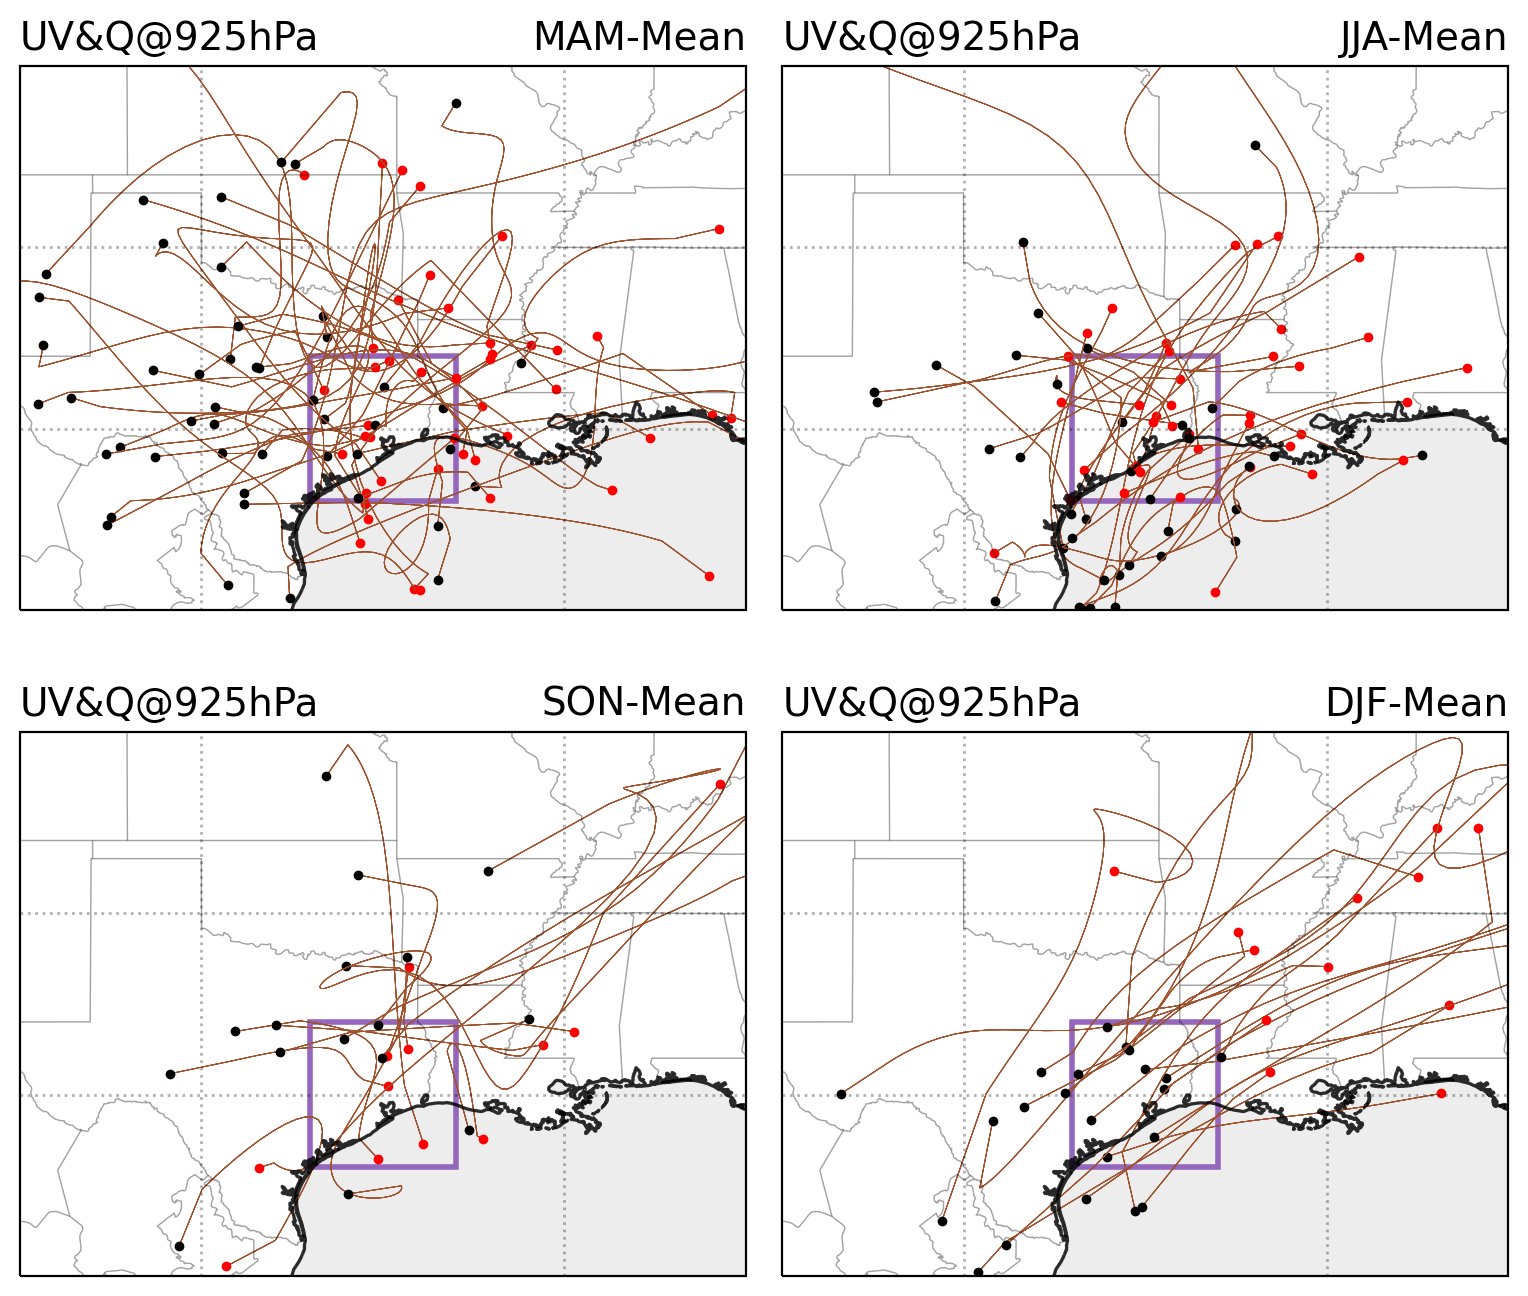

In [10]:
fig, axs = plt.subplots(
    2, 2, figsize=(8, 7), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "MPL_RdBu"
clev = [-1000]+list(np.linspace(-3,3,13))+[1000]
for i, season in enumerate(['MAM', 'JJA', 'SON', 'DJF']):
    ax = axs[cnt]
    plot_on_map(
        Path[f'{season}_mcs_0'],
        fig=fig, ax=ax,
        cmap=cmap, clev=clev, alpha=0.5
    )
    ax.set_title(f'{season}-Mean', loc='right', fontsize=14)
    ax.set_title(f'UV&Q@925hPa', loc='left', fontsize=14)

    cnt += 1

# plot_map.add_colorbar(
#     cs, axs, clev[1:-1:2],
#     orientation='horizontal', 
#     aspect=30, shrink=0.8,
#     pad=0.03, anchor=(0.2, 1.0)
# )
# plot_map.add_quiverkey(axs[-1], vplot, length=10, labelpos='N')

/tmp/ipykernel_14351/892885884.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("YlOrRd")


3 0.8125 0.9375 0.0625
18 0.47058823529411764 0.9705882352941176 0.029411764705882353
3 0.8 0.8666666666666667 0.13333333333333333
9 0.7631578947368421 0.7894736842105263 0.21052631578947367
10 0.5454545454545454 1.0 0.0
12 0.4782608695652174 0.9565217391304348 0.043478260869565216
5 0.7058823529411765 0.9411764705882353 0.058823529411764705
1 0.9444444444444444 0.8888888888888888 0.1111111111111111


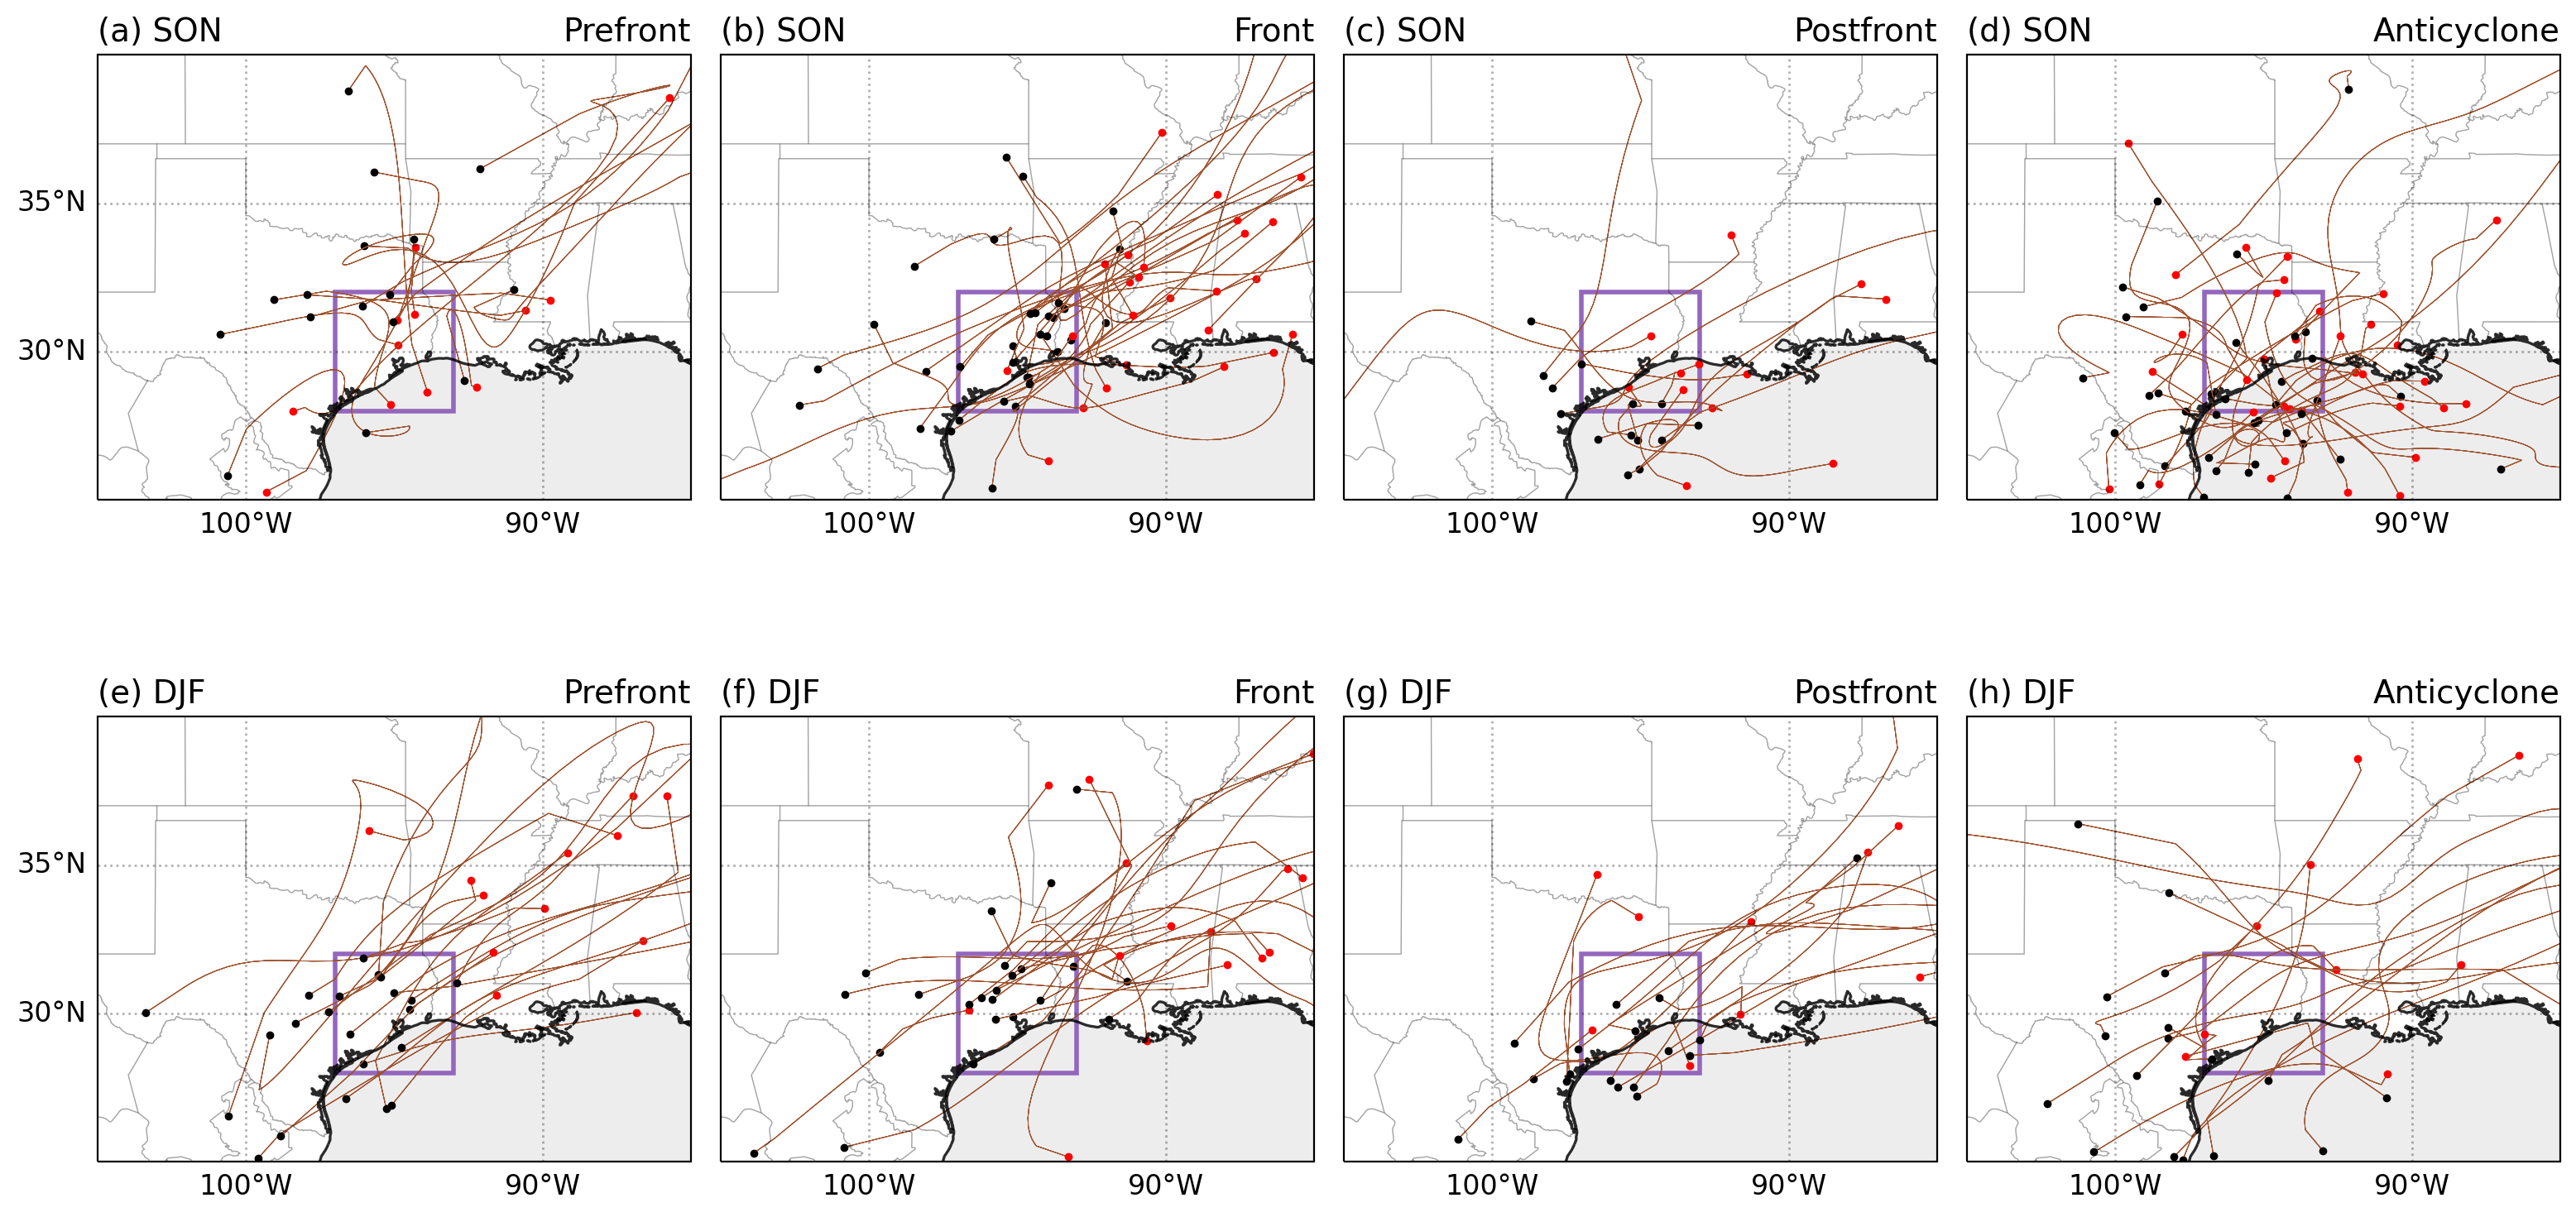

In [11]:
somtype = ['Prefront', 'Front', 'Postfront', 'Anticyclone']
fig, axs = plt.subplots(
    2, 4, figsize=(16, 8), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.25, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "MPL_RdBu"
clev = [-1000]+list(np.linspace(-3,3,13))+[1000]

for season in ['SON', 'DJF']:
    for i in np.arange(4):
        ax = axs[cnt]
        plot_on_map(
            Path[f'{season}_mcs_{i}'],
            fig=fig, ax=ax,
            cmap=cmap, clev=clev, alpha=0.5,
            drawylabel=True if i==0 else False, drawxlabel=True,
        )
        ax.set_title(f'{somtype[i]}', loc='right', fontsize=14)
        ax.set_title(f'({abcd[cnt]}) {season}', loc='left', fontsize=14)

        cnt += 1

# sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=20))
# ccs = plt.colorbar(sm, ax=axs, orientation='horizontal', aspect=45, shrink=0.68, pad=0.08, extend='max')

# ccs.ax.set_title('Track path with precipitation rate ($mm\ h^{-1}$)')

# plot_map.add_quiverkey(ccs.ax, vplot, x=0.83, y=-0.30, length=10, labelpos='N')

/tmp/ipykernel_14351/892885884.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("YlOrRd")


9 0.8163265306122449 0.9387755102040817 0.061224489795918366
8 0.8095238095238095 0.9761904761904762 0.023809523809523808
16 0.5897435897435898 0.9743589743589743 0.02564102564102564
11 0.78 0.94 0.06
6 0.8461538461538461 0.8205128205128205 0.1794871794871795
24 0.5 0.7916666666666666 0.20833333333333334
18 0.5813953488372093 0.6976744186046512 0.3023255813953488
12 0.7333333333333333 0.5555555555555556 0.4444444444444444
3 0.8125 0.9375 0.0625
18 0.47058823529411764 0.9705882352941176 0.029411764705882353
3 0.8 0.8666666666666667 0.13333333333333333
9 0.7631578947368421 0.7894736842105263 0.21052631578947367
10 0.5454545454545454 1.0 0.0
12 0.4782608695652174 0.9565217391304348 0.043478260869565216
5 0.7058823529411765 0.9411764705882353 0.058823529411764705
1 0.9444444444444444 0.8888888888888888 0.1111111111111111


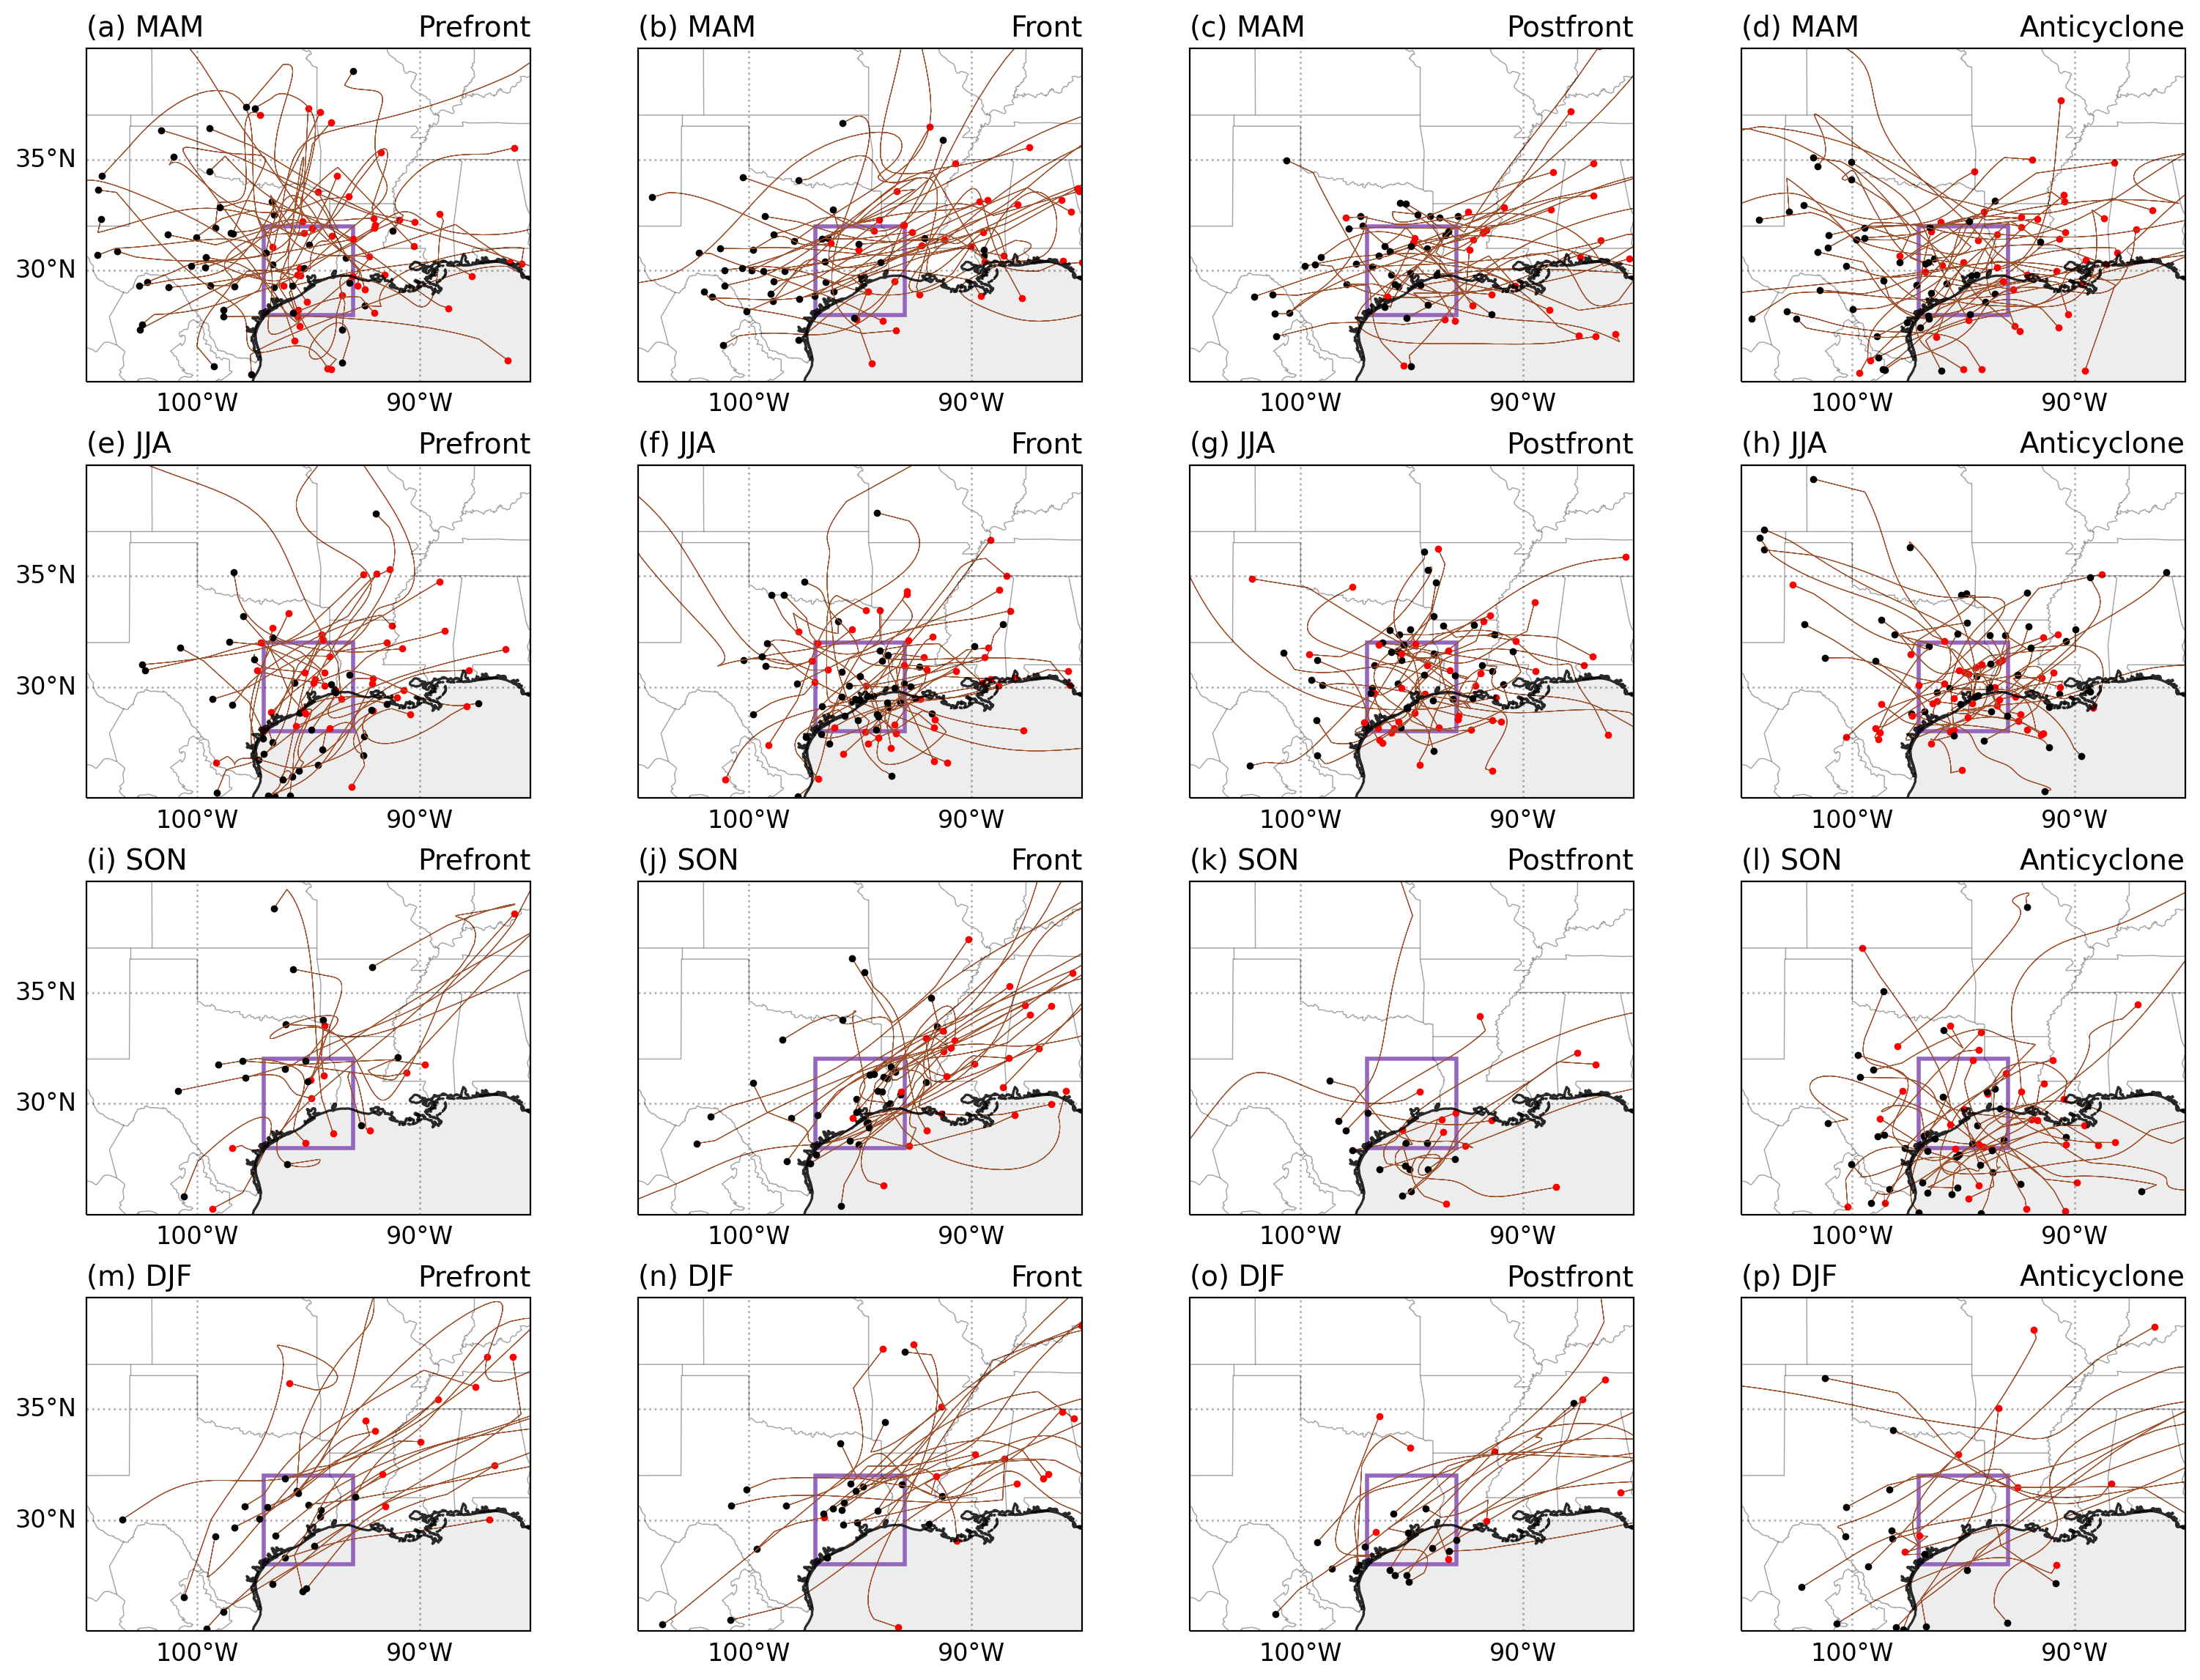

In [14]:
somtype = ['Prefront', 'Front', 'Postfront', 'Anticyclone']
fig, axs = plt.subplots(
    4, 4, figsize=(16, 12), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.25, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "MPL_RdBu"
clev = [-1000]+list(np.linspace(-3,3,13))+[1000]

for season in ['MAM', 'JJA', 'SON', 'DJF']:
    for i in np.arange(4):
        ax = axs[cnt]
        plot_on_map(
            Path[f'{season}_mcs_{i}'],
            fig=fig, ax=ax,
            cmap=cmap, clev=clev, alpha=0.5,
            drawylabel=True if i==0 else False, drawxlabel=True,
        )
        ax.set_title(f'{somtype[i]}', loc='right', fontsize=14)
        ax.set_title(f'({abcd[cnt]}) {season}', loc='left', fontsize=14)

        cnt += 1

# sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=20))
# ccs = plt.colorbar(sm, ax=axs, orientation='horizontal', aspect=45, shrink=0.68, pad=0.08, extend='max')
# ccs.ax.set_title('Track path with precipitation rate ($mm\ h^{-1}$)')
fig.savefig('paper/Figure9.pdf', bbox_inches='tight')
fig.savefig('paper/Figure9.png', format='png', bbox_inches='tight', dpi=300)


/tmp/ipykernel_14351/892885884.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("YlOrRd")


790 0.06729634002361275 0.9020070838252656 0.7709563164108618
521 0.06294964028776978 0.935251798561151 0.8165467625899281
715 0.0821566110397946 0.9024390243902439 0.8010269576379975
680 0.07482993197278912 0.9156462585034013 0.7428571428571429
3111 0.046875 0.8241421568627451 0.8100490196078431
1446 0.04365079365079365 0.8101851851851852 0.8068783068783069
1510 0.04490828589500316 0.8481973434535104 0.8064516129032258
2937 0.053496616177892364 0.8156622623267805 0.808250080567193


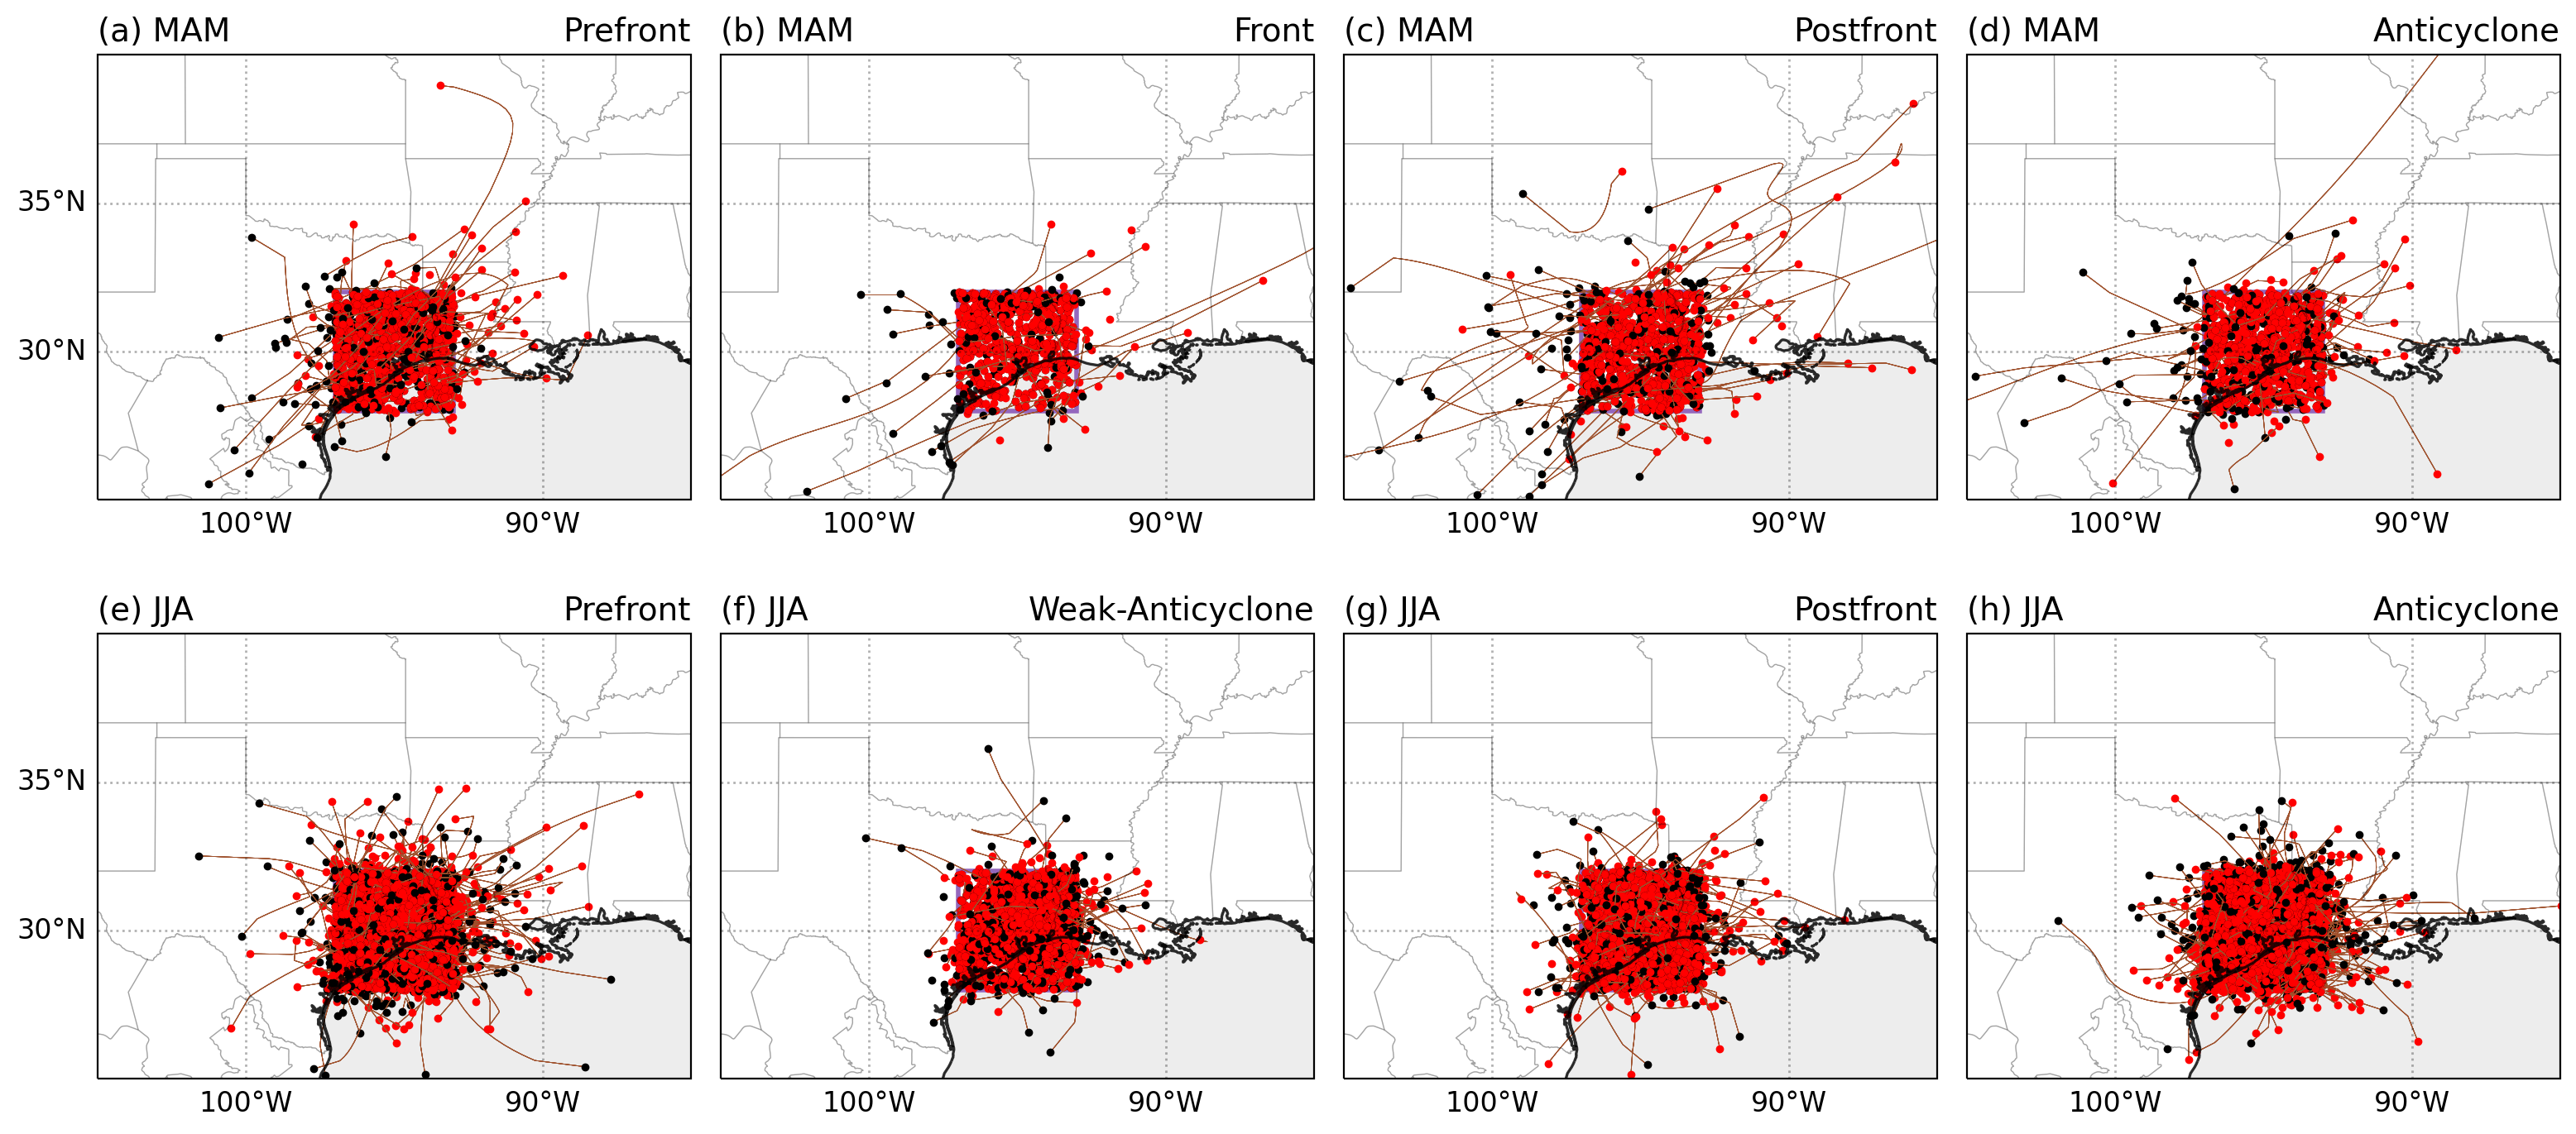

In [15]:
somtype_mam = ['Prefront', 'Front', 'Postfront', 'Anticyclone']
somtype_jja = ['Prefront', 'Weak-Anticyclone', 'Postfront', 'Anticyclone']
fig, axs = plt.subplots(
    2, 4, figsize=(16, 7), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.25, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "MPL_RdBu"
clev = [-1000]+list(np.linspace(-3,3,13))+[1000]

for season in ['MAM', 'JJA']:
    if season=='MAM': somtype = somtype_mam
    if season=='JJA': somtype = somtype_jja
    for i in np.arange(4):
        ax = axs[cnt]
        plot_on_map(
            Path[f'{season}_idc_{i}'],
            fig=fig, ax=ax,
            cmap=cmap, clev=clev, alpha=0.5,
            drawylabel=True if i==0 else False, drawxlabel=True,
        )
        ax.set_title(f'{somtype[i]}', loc='right', fontsize=14)
        ax.set_title(f'({abcd[cnt]}) {season}', loc='left', fontsize=14)

        cnt += 1
        
# sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=20))
# ccs = plt.colorbar(sm, ax=axs, orientation='horizontal', aspect=45, shrink=0.68, pad=0.08, extend='max')

# ccs.ax.set_title('Track path with precipitation rate ($mm\ h^{-1}$)')

# plot_map.add_quiverkey(ccs.ax, vplot, x=0.83, y=-0.30, length=10, labelpos='N')
fig.savefig('paper/Figure10.pdf', bbox_inches='tight')
fig.savefig('paper/Figure10.png', format='png', bbox_inches='tight', dpi=300)


/tmp/ipykernel_7930/1611410948.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("YlOrRd")


Text(0.5, 1.0, 'Track path with precipitation rate ($mm\\ h^{-1}$)')

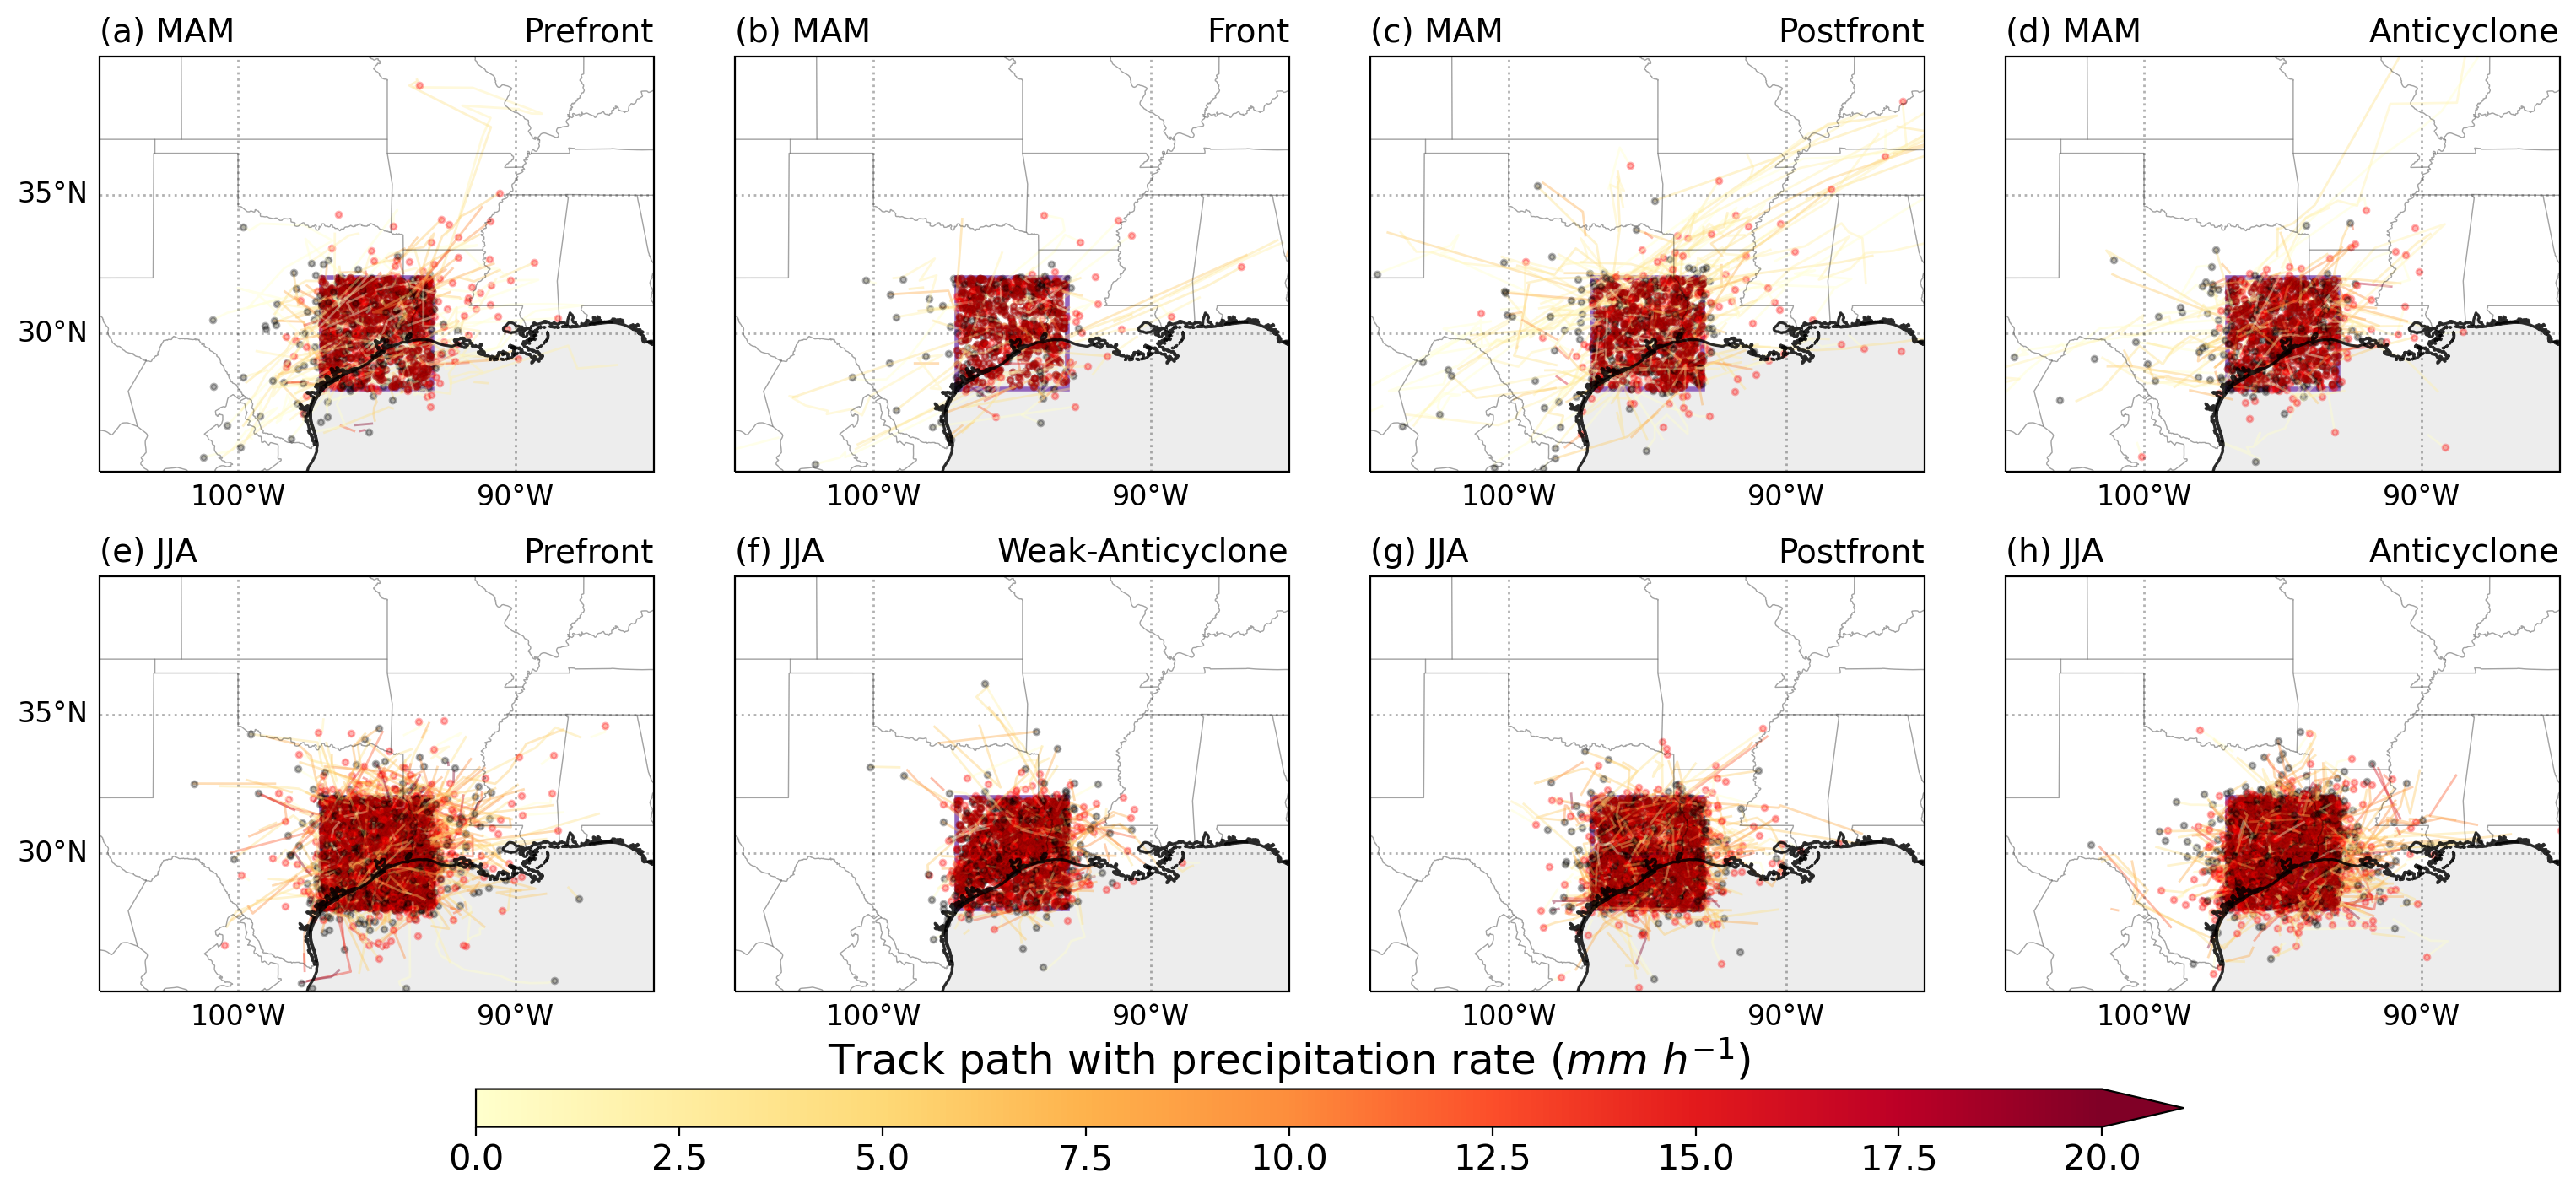

In [14]:
somtype_mam = ['Prefront', 'Front', 'Postfront', 'Anticyclone']
somtype_jja = ['Prefront', 'Weak-Anticyclone', 'Postfront', 'Anticyclone']
fig, axs = plt.subplots(
    2, 4, figsize=(16, 8), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.25, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "MPL_RdBu"
clev = [-1000]+list(np.linspace(-3,3,13))+[1000]

for season in ['MAM', 'JJA']:
    if season=='MAM': somtype = somtype_mam
    if season=='JJA': somtype = somtype_jja
    for i in np.arange(4):
        ax = axs[cnt]
        plot_on_map(
            Path[f'{season}_idc_{i}'],
            fig=fig, ax=ax,
            cmap=cmap, clev=clev, alpha=0.5,
            drawylabel=True if i==0 else False, drawxlabel=True,
        )
        ax.set_title(f'{somtype[i]}', loc='right', fontsize=14)
        ax.set_title(f'({abcd[cnt]}) {season}', loc='left', fontsize=14)

        cnt += 1
        
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=20))
ccs = plt.colorbar(sm, ax=axs, orientation='horizontal', aspect=45, shrink=0.68, pad=0.08, extend='max')

# ccs = plot_map.add_colorbar(
#     cs, axs, clev[1:-1:2],
#     orientation='horizontal', 
#     aspect=45, shrink=0.68,
#     pad=0.08, anchor=(0.5, 1.0)
# )
ccs.ax.set_title('Track path with precipitation rate ($mm\ h^{-1}$)')

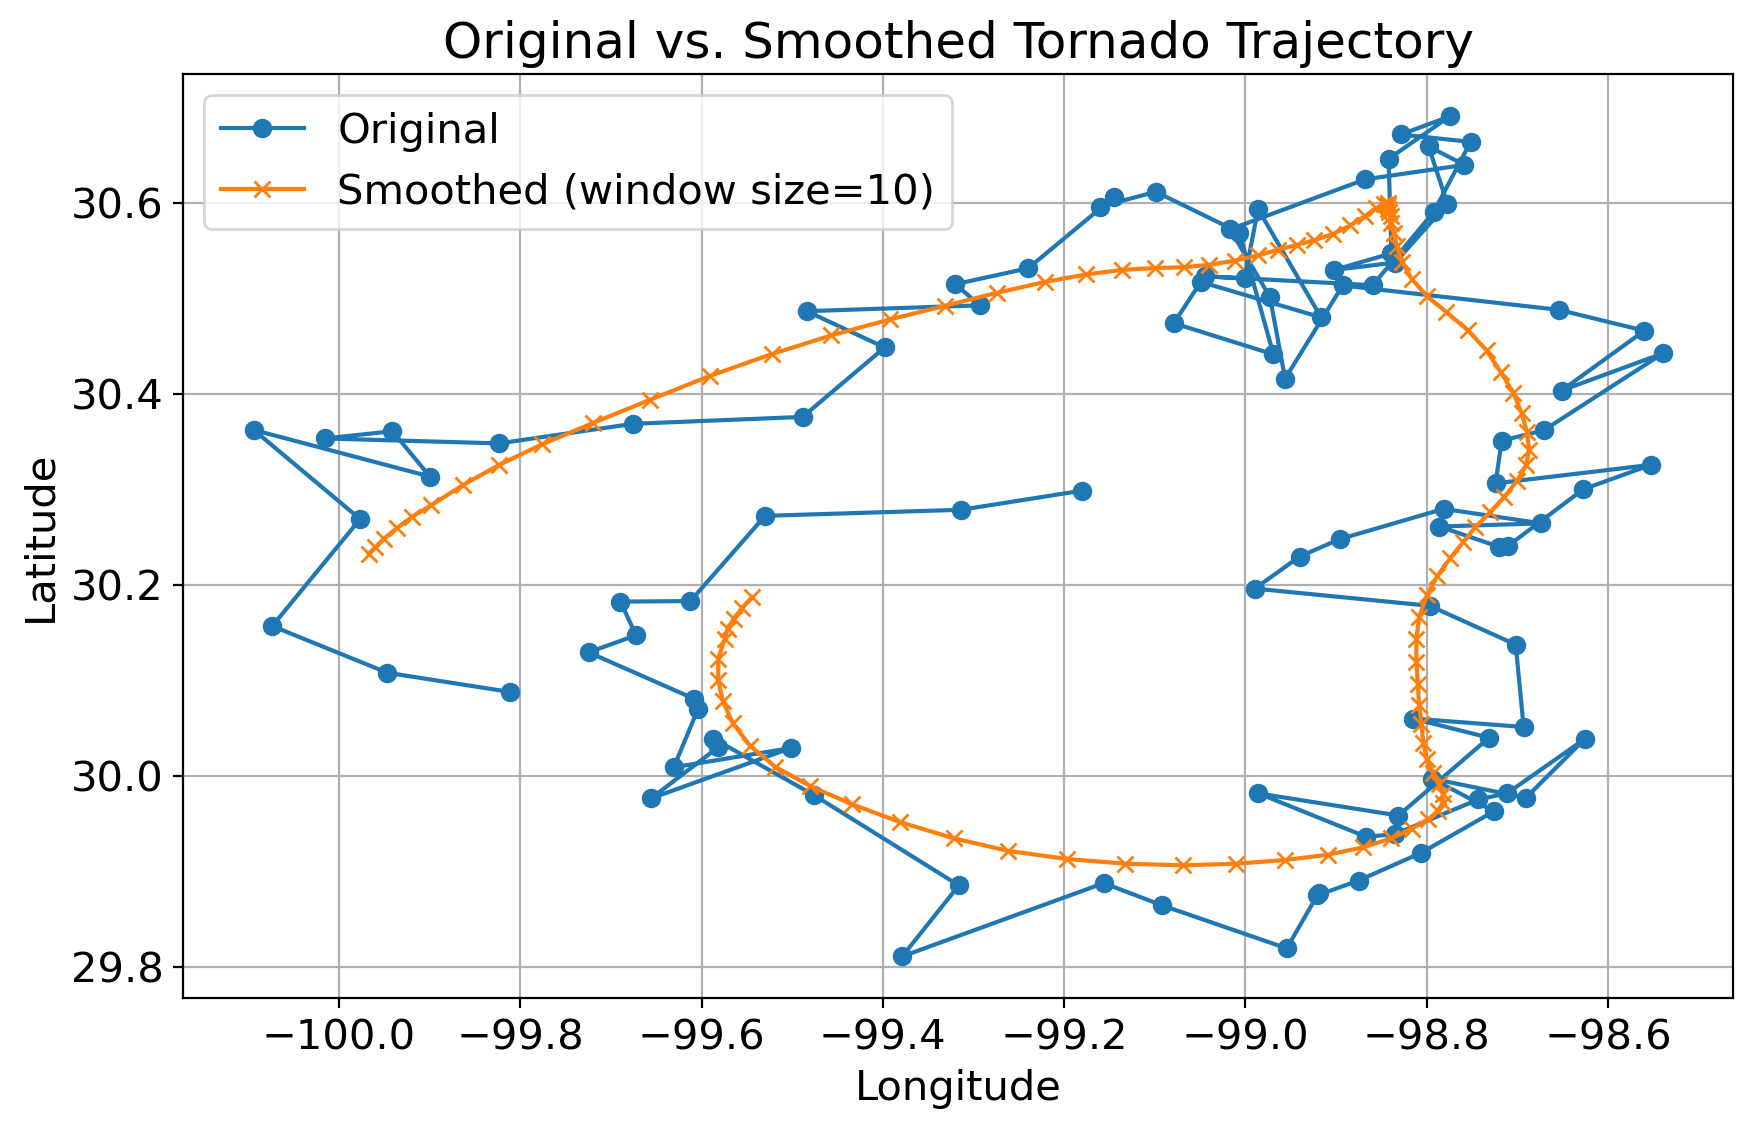

In [71]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Generate fake data with more data points and smoother trajectory
np.random.seed(0)
time = np.arange(0, 100, 1)
latitude = 30 + np.cumsum(np.random.normal(0, 0.05, len(time)))
longitude = -100 + np.cumsum(np.random.normal(0, 0.1, len(time)))

# Create an xarray dataset
data = xr.Dataset({
    'latitude': (('time',), latitude),
    'longitude': (('time',), longitude)
}, coords={'time': time})

# Define a smoothing function
def smooth_trajectory(da, window_size):
    smoothed_data = da.rolling(time=window_size, center=True, min_periods=2).mean()
    return smoothed_data

# Specify the window size for smoothing
window_size = 10

# Smooth latitude and longitude dimensions separately
smoothed_latitude = smooth_trajectory(data['latitude'], window_size)
smoothed_longitude = smooth_trajectory(data['longitude'], window_size)
smoothed_latitude = smooth_trajectory(smoothed_latitude, window_size)
smoothed_longitude = smooth_trajectory(smoothed_longitude, window_size)
# Create a new xarray dataset with smoothed data
smoothed_data = xr.Dataset({
    'latitude': smoothed_latitude,
    'longitude': smoothed_longitude
}, coords={'time': time})

# Plot original and smoothed trajectories
plt.figure(figsize=(10, 6))
plt.plot(data['longitude'], data['latitude'], marker='o', label='Original')
plt.plot(smoothed_data['longitude'], smoothed_data['latitude'], marker='x', label=f'Smoothed (window size={window_size})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Original vs. Smoothed Tornado Trajectory')
plt.grid(True)
plt.show()